In [ ]:
! gdown --id '1cpkR6c7n6oVVCdmW-phpvMwLlZjR4ghi' --output skull.zip
! unzip skull.zip

Permission denied: https://drive.google.com/uc?id=1cpkR6c7n6oVVCdmW-phpvMwLlZjR4ghi
Maybe you need to change permission over 'Anyone with the link'?
Archive:  skull.zip
replace skull/records_train_readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
CUDA_LAUNCH_BLOCKING=1

from pprint import pprint
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as sche
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random
import glob
import os
import csv
import numpy as np
from PIL import Image
import json
!pip install opencv-python
import cv2
from cv2 import Canny

# from dataset import SkullSet

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
# torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print('Device used:', device)

# with open(os.path.join('skull', 'records_train.json')) as f:
#     data = json.load(f)
# pprint(data['datainfo']['H1_00000000_00000181_00000001'])

Device used: cuda


In [ ]:
# Attempt to use canny edge

# print(raw_samples.size())
# # imgs = (255/2 * (np.asarray(raw_samples.squeeze()) + 1)).astype('uint8')
# # s = imgs[10]

# s = np.asarray(raw_samples.squeeze())[10]
# s = (s - s.min())/(s.max()-s.min())
# s = (255 * s).astype('uint8')


# edge_output = Canny(image=s, threshold1=250, threshold2=300)

# plt.subplot(121),plt.imshow(s,cmap = 'gray')
# plt.subplot(122),plt.imshow(edge_output,cmap = 'gray')

In [ ]:
# Visualize skeleton
'''
from google.colab.patches import cv2_imshow

# s = np.asarray(raw_samples.squeeze())[26]
# s = (s - s.min())/(s.max()-s.min())
# img = (255 * s).astype('uint8')
# # img = np.asarray(raw_samples.squeeze())[20]
# ret,img = cv2.threshold(img,130,255,cv2.THRESH_BINARY)

# Function for skeletonizing the image
def findSkeleton(im):
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    out = np.zeros(im.shape,np.uint8)

    flag = 0 
    while(not flag):
        eroded = cv2.erode(im, element)
        opened = cv2.dilate(eroded, element)
        opened = cv2.subtract(im,opened)
        out = cv2.bitwise_or(out,opened)
        im = eroded.copy()
        zeros = img.size - cv2.countNonZero(im)
        flag = 1 if (zeros == img.size) else 0
    kernel = np.ones((3,3),np.uint8)
    out = cv2.dilate(out,kernel)
    out = cv2.medianBlur(out, 5)
    ret,thresh = cv2.threshold(out,127,255,cv2.THRESH_BINARY_INV)
    return thresh

# output = findSkeleton(img)
# kernel = np.ones((3,3),np.uint8)
# output = cv2.dilate(output,kernel)
# output = cv2.medianBlur(output, 5)
# ret,thresh = cv2.threshold(output,127,255,cv2.THRESH_BINARY_INV)

# res = np.hstack((img, thresh))

# output = findSkeleton(img)
# # print(output.shape)
# cv2_imshow(cv2.resize(output, dsize=None,fx=0.5, fy=0.5))
'''

"\nfrom google.colab.patches import cv2_imshow\n\n# s = np.asarray(raw_samples.squeeze())[26]\n# s = (s - s.min())/(s.max()-s.min())\n# img = (255 * s).astype('uint8')\n# # img = np.asarray(raw_samples.squeeze())[20]\n# ret,img = cv2.threshold(img,130,255,cv2.THRESH_BINARY)\n\n# Function for skeletonizing the image\ndef findSkeleton(im):\n    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))\n    out = np.zeros(im.shape,np.uint8)\n\n    flag = 0 \n    while(not flag):\n        eroded = cv2.erode(im, element)\n        opened = cv2.dilate(eroded, element)\n        opened = cv2.subtract(im,opened)\n        out = cv2.bitwise_or(out,opened)\n        im = eroded.copy()\n        zeros = img.size - cv2.countNonZero(im)\n        flag = 1 if (zeros == img.size) else 0\n    kernel = np.ones((3,3),np.uint8)\n    out = cv2.dilate(out,kernel)\n    out = cv2.medianBlur(out, 5)\n    ret,thresh = cv2.threshold(out,127,255,cv2.THRESH_BINARY_INV)\n    return thresh\n\n# output = findSkeleton(img

In [ ]:
from google.colab.patches import cv2_imshow
def load(img_dir: str):
    img = np.load(img_dir)
    return (img - np.mean(img)) / np.std(img)

def patch_label(patch_loc, gts):
    ## patch_loc is the center of the patch
    for i in gts:
        if pow(i[0] - patch_loc[0], 2) + pow(i[1] - patch_loc[1], 2) < 1024:
            return 1
    return 0

def findSkeleton(im):
    ret,im = cv2.threshold(im,120,255,cv2.THRESH_BINARY)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    out = np.zeros(im.shape,np.uint8)

    flag = 0 
    while(not flag):
        eroded = cv2.erode(im, element)
        opened = cv2.dilate(eroded, element)
        opened = cv2.subtract(im,opened)
        out = cv2.bitwise_or(out,opened)
        im = eroded.copy()
        zeros = im.size - cv2.countNonZero(im)
        flag = 1 if (zeros == im.size) else 0
    kernel = np.ones((1,1),np.uint8)
    # out = cv2.dilate(out,kernel)
    # out = cv2.medianBlur(out, 5)
    ret,thresh = cv2.threshold(out,110,255,cv2.THRESH_BINARY_INV)
    return thresh

class ROIset(Dataset):
  def __init__(self, split_map=None, mode='train', root="skull/train", annotation_file="skull/records_train.json", transform=None):
    super().__init__()
    self.mode = mode
    self.root = root
    self.transform = transform


    with open(annotation_file, "r") as json_file:
      records = json.load(json_file)
      self.record = records["datainfo"]

    if mode == 'test' or mode == 'gt':
        if split_map is None:
            self.img_dirs = sorted(np.asarray(glob.glob(os.path.join(root, '*'))))
            print("# of cases: ", len(self.img_dirs))
        else:
            split_map = split_map == False
            self.img_dirs = sorted(np.asarray(glob.glob(os.path.join(root, '*')))[split_map])
            print("# of cases: ", len(self.img_dirs))
        
        if mode == 'test':
          self.candidates = []
          p_count = 0
          for p in self.img_dirs:
            print("Patient # ", p_count+1)
            p_count += 1

            fns = sorted(glob.glob(os.path.join(p, '*')))
            imgs = np.asarray( [load(i) for i in fns], dtype=np.float32)
            case_candidates = []
            for n in range(imgs.shape[0]):
              norm = (imgs[n] - imgs[n].min())/(imgs[n].max()-imgs[n].min())
              norm = (255 * norm).astype('uint8')
              skeleton = findSkeleton(norm)
              # cmp = np.hstack((norm, skeleton))
              # cv2_imshow(cv2.resize(cmp, dsize=None,fx=0.5, fy=0.5))

              skeleton = np.array(skeleton != 255)
              candidates = np.argwhere(skeleton == True)
              cen_dist_thresh = np.asarray([ pow((c[0]-256),2) + pow((c[1]-256),2) < 65536 for c in candidates])
              candidates = candidates[cen_dist_thresh]
              case_candidates.append(candidates)
            self.candidates.append(case_candidates)
    
    elif mode == 'train' or mode == 'eval':
        if mode == 'eval':
            split_map = split_map == False
        self.img_dirs = sorted(np.asarray(glob.glob(os.path.join(root, '*')))[split_map])
        print("# of cases: ", len(self.img_dirs))


        self.sampled_coords = []

        p_count = 0
        for p in self.img_dirs:
          print("Patient # ", p_count+1)
          p_count += 1
       
          fns = sorted(glob.glob(os.path.join(p, '*')))
          imgs = np.asarray( [load(i) for i in fns], dtype=np.float32)         
          slice_names = [os.path.basename(os.path.normpath(n))[:-4] for n in fns]
          case_sampled_coords = []
#=============================================================================
          total_patch_num = 100
          gt_coords = [np.asarray(self.record[n]['coords']) for n in slice_names]

          for n in range(imgs.shape[0]):
            fracNum = gt_coords[n].shape[0]

            norm = (imgs[n] - imgs[n].min())/(imgs[n].max()-imgs[n].min())
            norm = (255 * norm).astype('uint8')
            skeleton = findSkeleton(norm)
            # cmp = np.hstack((norm, skeleton))
            # cv2_imshow(cv2.resize(cmp, dsize=None,fx=0.5, fy=0.5))

            skeleton = np.array(skeleton != 255)
            candidates = np.argwhere(skeleton == True)
            cen_dist_thresh = np.asarray([ pow((c[0]-256),2) + pow((c[1]-256),2) < 65536 for c in candidates])
            candidates = candidates[cen_dist_thresh]
            # case_candidates.append(candidates)

            broken_patch_num = min(fracNum*9, total_patch_num - 2)
            # print("broken_patch:", broken_patch_num, end=' ')
            # rand_coords = candidates[torch.randint(len(candidates), (100 - broken_patch_num,))]
            sample_dist = 8
            arg = np.asarray([c[0] % sample_dist == 0 or c[1] % sample_dist == 0 for c in candidates])
            if len(arg) > 0:
              spaced_candidates = candidates[arg]
              # print(len(spaced_candidates))
            else:
              print("no spaced candidates")
              spaced_candidates = np.empty([0, 2])

            # print(spaced_candidates.shape[0])
            if len(spaced_candidates) >= total_patch_num - broken_patch_num: 
              sampled_coords = spaced_candidates[ torch.randperm(len(spaced_candidates))[:total_patch_num-broken_patch_num] ]
            else:
              sampled_coords = np.concatenate((spaced_candidates, np.array(candidates[ torch.randperm(len(candidates))[:total_patch_num-broken_patch_num-len(spaced_candidates)] ], ndmin=2) ))
            
            if sampled_coords.shape[0] < total_patch_num - broken_patch_num:
              sampled_coords = np.concatenate((sampled_coords,  np.zeros((total_patch_num - broken_patch_num - sampled_coords.shape[0], 2))))

            # print(sampled_coords)
            shift_dist = 12
            for c in range(len(sampled_coords)):
              prob = np.random.randint(9)
              if prob != 0:
                dir = np.random.randint(8)
                sampled_coords[c] = np.array([round(sampled_coords[c][0] + shift_dist * dir * np.pi/4),
                                        round(sampled_coords[c][1] + shift_dist * dir * np.pi/4)])

            # print(sampled_coords)
            case_sampled_coords.append(sampled_coords)
          self.sampled_coords.append(case_sampled_coords)
#===============================================================================


  def __len__(self):
    return len(self.img_dirs)



  def __getitem__(self, idx):
    # print("patient no.", idx)
    fns = sorted(glob.glob(os.path.join(self.img_dirs[idx], '*')))
    imgs = np.asarray( [load(i) for i in fns], dtype=np.float32)                 
    slice_names = [os.path.basename(os.path.normpath(n))[:-4] for n in fns]
    

    size = 64
    if self.mode == 'gt':
      gt_coords = [np.asarray(self.record[n]['coords']) for n in slice_names]
      gt_labels = [np.asarray(self.record[n]['label']) for n in slice_names]
      return slice_names, gt_labels, gt_coords

    elif self.mode == 'test':
      total_patch_num = 100
      all_patches = torch.empty((0,3,size,size))
      all_sampled_coords = torch.empty((0,2))
      all_z = torch.empty((0), dtype=torch.float32)

      for n in range(imgs.shape[0]):
        z = torch.full( (total_patch_num,), n * 1.0 / imgs.shape[0])

        candidates = self.candidates[idx][n]
        
        sample_dist = 8
        sample_num = 100

        arg = np.asarray([c[0] % sample_dist == 0 or c[1] % sample_dist == 0 for c in candidates])

        if len(arg) > 0:
          spaced_candidates = candidates[arg]
        else:
          print("no spaced candidates")
          spaced_candidates = np.empty([0, 2])

        if len(spaced_candidates) >= sample_num: 
          sampled_coords = spaced_candidates[ torch.randperm(len(spaced_candidates))[:sample_num] ]
        else:
          sampled_coords = np.concatenate((spaced_candidates, np.array(candidates[ torch.randperm(len(candidates))[:sample_num-len(spaced_candidates)] ], ndmin=2) ))
        if sampled_coords.shape[0] < sample_num:
          sampled_coords = np.concatenate((sampled_coords,  np.zeros((sample_num - sampled_coords.shape[0], 2))))

        # origin_sampled_coords = np.array(sampled_coords)
        shift_dist = 12
        aug_num = 8
        # for dir in range(aug_num):
        #     dx = shift_dist * np.cos(dir * np.pi/4)
        #     dy = shift_dist * np.sin(dir * np.pi/4)
        #     aug_coords = np.asarray([np.array([c[0] + dx, c[1] + dy]) for c in origin_sampled_coords])
        #     # print(aug_coords.shape)
        #     sampled_coords  = np.concatenate( (sampled_coords, aug_coords) )
        #     # print(sampled_coords.shape)

        # print(sampled_coords.shape)
        
        img = transforms.ToPILImage()(imgs[n])

        if n > 0:
          pre_img = transforms.ToPILImage()(imgs[n-1])
        else:
          pre_img = transforms.ToPILImage()(imgs[n])
        if n < imgs.shape[0] - 1:
          nxt_img = transforms.ToPILImage()(imgs[n+1])
        else:
          nxt_img = transforms.ToPILImage()(imgs[n])

        patches = torch.Tensor(np.asarray([np.asarray(TF.crop(img, coord[0]-size/2, coord[1]-size/2, size, size)) for coord in sampled_coords])).unsqueeze(1)
        pre_patches = torch.Tensor(np.asarray([np.asarray(TF.crop(pre_img, coord[0]-size/2, coord[1]-size/2, size, size)) for coord in sampled_coords])).unsqueeze(1)
        nxt_patches = torch.Tensor(np.asarray([np.asarray(TF.crop(nxt_img, coord[0]-size/2, coord[1]-size/2, size, size)) for coord in sampled_coords])).unsqueeze(1)
        seq_patches = torch.cat((pre_patches, patches, nxt_patches), dim=1)

        sampled_coords = torch.Tensor(sampled_coords)

        all_patches = torch.cat((all_patches, seq_patches),dim=0)
        all_sampled_coords = torch.cat((all_sampled_coords, sampled_coords), dim=0)
        all_z = torch.cat((all_z, z))
        
      all_patches = TF.resize(all_patches, (75, 75))
      all_sampled_coords = all_sampled_coords.to(dtype=torch.int32)
      all_sampled_coords[:,[1,0]] = all_sampled_coords[:,[0,1]]

      # print(all_patches.size())
      return all_patches, all_sampled_coords, slice_names, all_z

#======================================================================================================
    elif self.mode == 'train' or self.mode == 'eval':
      total_patch_num = 100

      case_sampled_coords = self.sampled_coords[idx]
      gt_coords = [np.asarray(self.record[n]['coords']) for n in slice_names]
      # label = torch.Tensor(np.asarray( [ self.record[n]['label'] for n in slice_names ] ))
      # print("slices:", imgs.shape[0])

      all_patches = torch.empty((0,3,size,size))
      all_labels = torch.empty((0), dtype=torch.int64)
      all_sampled_coords = torch.empty((0,2), dtype=torch.int32)
      all_z = torch.empty((0), dtype=torch.float32)

      for n in range(imgs.shape[0]):
        z = torch.full( (total_patch_num,), n * 1.0 / imgs.shape[0])
        fracNum = gt_coords[n].shape[0]
        # print("slice ", n, ": ", fracNum)

        # candidates = case_candidates[n]

        broken_patch_num = min(fracNum*9, total_patch_num - 2)
        # # print("broken_patch:", broken_patch_num, end=' ')
        # # rand_coords = candidates[torch.randint(len(candidates), (100 - broken_patch_num,))]
        # sample_dist = 8
        # arg = np.asarray([c[0] % sample_dist == 0 or c[1] % sample_dist == 0 for c in candidates])
        # if len(arg) > 0:
        #   spaced_candidates = candidates[arg]
        # else:
        #   print("no spaced candidates")
        #   spaced_candidates = np.empty([0, 2])

        # # print(spaced_candidates.shape[0])
        # if len(spaced_candidates) >= total_patch_num - broken_patch_num: 
        #   sampled_coords = spaced_candidates[ torch.randperm(len(spaced_candidates))[:total_patch_num-broken_patch_num] ]
        # else:
        #   sampled_coords = np.concatenate((spaced_candidates, np.array(candidates[ torch.randperm(len(candidates))[:total_patch_num-broken_patch_num-len(spaced_candidates)] ], ndmin=2) ))
        sampled_coords = case_sampled_coords[n]


        
        # print(sampled_coords)

        img = transforms.ToPILImage()(imgs[n])

        if n > 0:
          pre_img = transforms.ToPILImage()(imgs[n-1])
        else:
          pre_img = transforms.ToPILImage()(imgs[n])
        if n < imgs.shape[0] - 1:
          nxt_img = transforms.ToPILImage()(imgs[n+1])
        else:
          nxt_img = transforms.ToPILImage()(imgs[n])

        patches = torch.Tensor(np.asarray([np.asarray(TF.crop(img, coord[0]-size/2, coord[1]-size/2, size, size)) for coord in sampled_coords])).unsqueeze(1)
        pre_patches = torch.Tensor(np.asarray([np.asarray(TF.crop(pre_img, coord[0]-size/2, coord[1]-size/2, size, size)) for coord in sampled_coords])).unsqueeze(1)
        nxt_patches = torch.Tensor(np.asarray([np.asarray(TF.crop(nxt_img, coord[0]-size/2, coord[1]-size/2, size, size)) for coord in sampled_coords])).unsqueeze(1)
        seq_patches = torch.cat((pre_patches, patches, nxt_patches), dim=1)

        # labels = torch.zeros((len(sampled_coords)), dtype=torch.int64)
        labels = torch.Tensor(np.asarray([patch_label(c, gt_coords[n]) for c in sampled_coords ])).to(torch.int64)
        # print(labels.sum().item())

        frac_label = 1
        shift_dist = 12
        aug_num = 8

        if fracNum > 0:
          broken_patches = torch.Tensor(np.asarray([np.asarray(TF.crop(img, coord[1]-size/2, coord[0]-size/2, size, size)) for coord in gt_coords[n]])).unsqueeze(1)
          pre_broken_patches = torch.Tensor(np.asarray([np.asarray(TF.crop(pre_img, coord[1]-size/2, coord[0]-size/2, size, size)) for coord in gt_coords[n]])).unsqueeze(1)
          nxt_broken_patches = torch.Tensor(np.asarray([np.asarray(TF.crop(nxt_img, coord[1]-size/2, coord[0]-size/2, size, size)) for coord in gt_coords[n]])).unsqueeze(1)
          seq_broken_patches = torch.cat((pre_broken_patches, broken_patches, nxt_broken_patches), dim=1)

          broken_coords = np.array([np.array([coord[1], coord[0]]) for coord in gt_coords[n]], ndmin=2)
          sampled_coords = np.concatenate(( sampled_coords, broken_coords ), axis=0)
          for dir in range(aug_num):
            dx = shift_dist * np.cos(dir * np.pi/4)
            dy = shift_dist * np.sin(dir * np.pi/4)

            aug = torch.Tensor(np.asarray([np.asarray(TF.crop(img, coord[1]-size/2 + dx, coord[0]-size/2 + dy, size, size)) for coord in gt_coords[n]])).unsqueeze(1)
            pre_aug = torch.Tensor(np.asarray([np.asarray(TF.crop(pre_img, coord[1]-size/2 + dx, coord[0]-size/2 + dy, size, size)) for coord in gt_coords[n]])).unsqueeze(1)
            nxt_aug = torch.Tensor(np.asarray([np.asarray(TF.crop(nxt_img, coord[1]-size/2 + dx, coord[0]-size/2 + dy, size, size)) for coord in gt_coords[n]])).unsqueeze(1)
            seq_aug = torch.cat((pre_aug, aug, nxt_aug), dim=1)

            aug_coords = np.array([np.array([coord[1] + dx, coord[0] + dy]) for coord in gt_coords[n]], ndmin=2)
            sampled_coords = np.concatenate(( sampled_coords, aug_coords ), axis=0)
            seq_broken_patches = torch.cat( (seq_broken_patches, seq_aug) , dim=0)

          # h_flip = np.array([ np.asarray(transforms.RandomHorizontalFlip(p=1.0)(transforms.ToPILImage()(patch))) for patch in broken_patches])
          # v_flip = np.array([ np.asarray(transforms.RandomVerticalFlip(p=1.0)(transforms.ToPILImage()(patch))) for patch in broken_patches])
          # hv_flip = np.array([ np.asarray(TF.rotate( transforms.ToPILImage()(patch), 180 )) for patch in broken_patches])
          seq_broken_patches = seq_broken_patches[:broken_patch_num]

          # print("broken:", broken_patches.size()[0], end=' ')
          broken_labels = torch.ones((broken_patch_num), dtype=torch.uint8)
          # broken_labels = torch.full((broken_patch_num,), frac_label, dtype=torch.uint8)
          seq_patches = torch.cat((seq_patches, seq_broken_patches), dim=0)
          labels = torch.cat((labels, broken_labels))
        # print(patches.size())

        all_patches = torch.cat((all_patches, seq_patches))
        all_labels = torch.cat((all_labels, labels))
        sampled_coords = torch.Tensor(sampled_coords).to(torch.int32)
        all_sampled_coords = torch.cat((all_sampled_coords, sampled_coords))
        all_z = torch.cat((all_z, z))

      all_patches = TF.resize(all_patches, (75, 75) )
      r=torch.randperm(all_patches.size()[0])
      all_patches = all_patches[r]
      all_labels = all_labels[r]
      all_sampled_coords = all_sampled_coords[r]
      all_z = all_z[r]

      return all_patches, all_labels, all_sampled_coords, all_z

In [ ]:
torch.manual_seed(123)
r=torch.randperm(1116)[:1006]
split_map = torch.zeros(1116, dtype=torch.bool)
split_map[r] = True

testset = ROIset(mode='test', root='skull/test')
val_test_set = ROIset(split_map=split_map ,mode='test', root='skull/train')
val_gt_set = ROIset(split_map=split_map ,mode='gt', root='skull/train')

# trainset = ROIset(split_map=split_map, mode='train', root='skull/train', annotation_file="skull/records_train.json")
# valset = ROIset(split_map=split_map, mode='eval', root='skull/train', annotation_file="skull/records_train.json")  


# train_loader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=4)
# val_loader = DataLoader(valset, batch_size=1, shuffle=True, num_workers=1)

test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=1)
val_test_loader = DataLoader(val_test_set, batch_size=1, shuffle=False, num_workers=1)
val_gt_loader = DataLoader(val_gt_set, batch_size=1, shuffle=False, num_workers=1)


# of cases:  130
Patient #  1
Patient #  2
Patient #  3
Patient #  4
Patient #  5
Patient #  6
Patient #  7
Patient #  8
Patient #  9
Patient #  10
Patient #  11
Patient #  12
Patient #  13
Patient #  14
Patient #  15
Patient #  16
Patient #  17
Patient #  18
Patient #  19
Patient #  20
Patient #  21
Patient #  22
Patient #  23
Patient #  24
Patient #  25
Patient #  26
Patient #  27
Patient #  28
Patient #  29
Patient #  30
Patient #  31
Patient #  32
Patient #  33
Patient #  34
Patient #  35
Patient #  36
Patient #  37
Patient #  38
Patient #  39
Patient #  40
Patient #  41
Patient #  42
Patient #  43
Patient #  44
Patient #  45
Patient #  46
Patient #  47
Patient #  48
Patient #  49
Patient #  50
Patient #  51
Patient #  52
Patient #  53
Patient #  54
Patient #  55
Patient #  56
Patient #  57
Patient #  58
Patient #  59
Patient #  60
Patient #  61
Patient #  62
Patient #  63
Patient #  64
Patient #  65
Patient #  66
Patient #  67
Patient #  68
Patient #  69
Patient #  70
Patient #  7

In [ ]:
dataiter = iter(test_loader)
raw_samples, labels, coords, z = dataiter.next()
print(raw_samples.size())
# print(labels.size())

# test_dataiter = iter(test_loader)
# test_samples, test_coords, test_names = test_dataiter.next()
# print(test_samples.size())
# print(test_coords.size())
# print(test_names)

torch.Size([1, 2800, 3, 75, 75])


torch.Size([100, 3, 75, 75])
tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0])


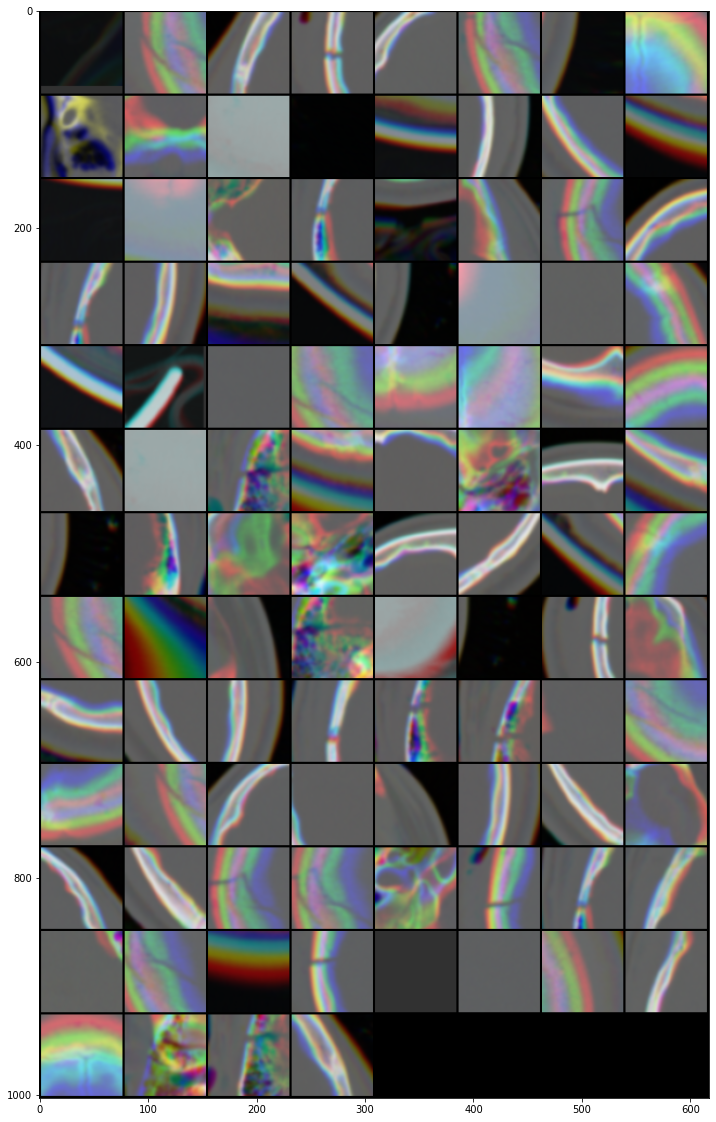

In [ ]:
slice_num = 20
samples = raw_samples.squeeze()[slice_num*100:slice_num*100+100,:,:,:]
# samples = raw_samples.squeeze().unsqueeze(dim=1).expand(-1, 3, -1, -1)[slice_num*100:slice_num*100+100,:,:,:]
print(samples.size())

torch.set_printoptions(profile="full")
print(labels.squeeze()[slice_num*100:slice_num*100+100])

# r=torch.randperm(100)
# print(labels.squeeze()[slice_num*100:slice_num*100+100][r])
# samples = samples[r]

# print('Digits in each batch:', imgs.shape, imgs.dtype)

plt.figure(figsize = (20,20))
plt.imshow(np.transpose(vutils.make_grid(samples.to(device), padding=2, normalize=True, nrow=8).cpu(),(1,2,0)))

In [ ]:
class Full_model(nn.Module):
    def __init__(self, model, dim = 1003, projection_size = 2, hidden_size = 1024):
        super().__init__()
        self.model = model
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(hidden_size, projection_size)
        )

    def forward(self, x, c, z):
        x = self.model(x)
        # print(x.size())
        # print(c.size())
        # print(z.size())
        x = torch.cat((x, c, z.unsqueeze(dim=1)), dim=1)
        return self.net(x)

model = models.inception_v3(pretrained=True, aux_logits=False).to(device)
model = Full_model(model).to(device)
# print(model)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=1, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
def val(model, val_loader, sample_num=5):
  # criterion = nn.CrossEntropyLoss()
  criterion = FocalLoss()
  model.eval()  # Important: set evaluation mode
  val_loss = 0
  correct = 0
  total_patches = 0
  tp = 0
  fp = 0
  fn = 0
  broken_total = 0

  with torch.no_grad(): # This will free the GPU memory used for back-prop
    for batch_idx, (case_data, case_target, case_coords, case_z) in enumerate(val_loader):
      if batch_idx >= sample_num:
        break
      case_data = case_data.squeeze()
      # case_data = case_data.squeeze().unsqueeze(dim=1).expand(-1, 3, -1, -1)
      case_target = case_target.squeeze()
      case_coords = case_coords.squeeze()
      case_z = case_z.squeeze()

      total_patches += case_data.size()[0]

      sub_batch_len = 100
      sub_data = torch.split(case_data, sub_batch_len)
      sub_target = torch.split(case_target, sub_batch_len)
      sub_coords = torch.split(case_coords, sub_batch_len)
      sub_z = torch.split(case_z, sub_batch_len)

      tp_per_patient = 0
      fp_per_patient = 0
      fn_per_patient = 0
      case_broken = case_target.sum(dim=0).item()
      broken_total += case_broken
      for idx in range(len(sub_data)):
        data, target, coords, z = sub_data[idx].to(device), sub_target[idx].to(device), sub_coords[idx].to(device), sub_z[idx].to(device)
        output = model(data, coords, z)
        val_loss += criterion(output, target).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        tp_per_patient += pred.eq(target.view_as(pred))[target == 1].sum().item()
        fp_per_patient += pred.ne(target.view_as(pred))[target == 0].sum().item()
        fn_per_patient += pred.ne(target.view_as(pred))[target == 1].sum().item()
      tp += tp_per_patient
      fp += fp_per_patient
      fn += fn_per_patient

      if case_broken != 0:
        print("Patient ", batch_idx+1, " recall:", tp_per_patient, "/", case_broken, '({:.0f}%)'.format(100.0 * tp_per_patient/case_broken))
      else:
        print("Patient ", batch_idx+1, " recall:", tp_per_patient, "/", case_broken)

    val_loss /= len(val_loader.dataset)
  if total_patches > 0:
    acc = correct / total_patches
  else: acc = 0
  try:
    f1_score = 2.*tp / (2*tp+fp+fn)
    print('\nVal set: TP:{}, FP:{}, FN:{},  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Recall: {:.0f}%, F1 score: {:.0f}%\n'.format(
        tp, fp, fn, val_loss, correct, total_patches, 100. * correct / total_patches, 100.*tp/broken_total, 100. * f1_score ))
    return acc, f1_score
  except ZeroDivisionError as e:
    print(e)
    return 0,0

In [ ]:
def save_model(name, model, optimizer, acc, f1):
    state = {'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'acc' : acc,
        'f1' : f1,
        }
    torch.save(state, name)
    print('model saved to ', name)

def train(model, train_loader, val_loader, epoch, optimizer, criterion, save_interval=225, log_interval=300, val_interval=30):
    model.train()  # Important: set training mode

    max_f1 = 0
    # try: 
    state = torch.load('drive/MyDrive/skull_latest.pth')
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    # max_f1 = state['f1']
    # print('model loaded from drive/MyDrive/DLCV_4_2_C_max2.pth')
    # print("f1:", max_f1)

    # except Exception as e:
    #   print(e)
    #   pass

    iteration = 0
    for ep in range(epoch):
        for batch_idx, (case_data, case_target, case_coords, case_z) in enumerate(train_loader):
            case_data = case_data.squeeze()
            # case_data = case_data.squeeze().unsqueeze(dim=1).expand(-1, 3, -1, -1)
            case_target = case_target.squeeze()
            case_coords = case_coords.squeeze()
            case_z = case_z.squeeze()

            sub_batch_len = 100
            sub_data = torch.split(case_data, sub_batch_len)
            sub_target = torch.split(case_target, sub_batch_len)
            sub_coords = torch.split(case_coords, sub_batch_len)
            sub_z = torch.split(case_z, sub_batch_len)

            sub_iteration = 0
            for idx in range(len(sub_data)):
                data, target, coords, z = sub_data[idx].to(device), sub_target[idx].to(device), sub_coords[idx].to(device), sub_z[idx].to(device)
                # print(data.size(), " ", target.size())

                optimizer.zero_grad()
                output = model(data, coords, z)
                # print(target)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                if sub_iteration % log_interval == 0:
                  print('Epoch {} / Patient {} [{}/{} ({:.0f}%)]/[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                    idx * sub_batch_len, case_data.size()[0], 100. * idx * sub_batch_len / case_data.size()[0],
                     loss.item()))
                sub_iteration += 1
                
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     ep, batch_idx, len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader), loss.item()))
            iteration += 1
            
            if batch_idx % val_interval == 0:
                acc, f1 = val(model, val_loader) # Evaluate at the end of each epoch
                save_model('drive/MyDrive/skull_latest.pth', model, optimizer, acc=acc, f1=f1)
                if f1 > max_f1:
                  # save_model('drive/MyDrive/skull.pth', model, optimizer, acc=acc, f1=f1)
                  max_f1 = f1

optimizer = optim.Adam(model.parameters(), lr=0.0000001)
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
train(model, train_loader, val_loader, 10, optimizer, criterion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 / Patient 0 [0/1006 (0%)]/[0/2500 (0%)]	Loss: 0.232736
Patient  1  recall: 0 / 0
Patient  2  recall: 0 / 0
Patient  3  recall: 0 / 0
Patient  4  recall: 88 / 107 (82%)
Patient  5  recall: 0 / 0

Val set: TP:88, FP:352, FN:19,  Average loss: 0.1896, Accuracy: 14429/14800 (97%), Recall: 82%, F1 score: 32%

model saved to  drive/MyDrive/skull_latest.pth
Epoch 0 / Patient 1 [100/1006 (0%)]/[0/2600 (0%)]	Loss: 0.168981
Epoch 0 / Patient 2 [200/1006 (0%)]/[0/3300 (0%)]	Loss: 0.053185
Epoch 0 / Patient 3 [300/1006 (0%)]/[0/3000 (0%)]	Loss: 0.043491
Epoch 0 / Patient 4 [400/1006 (0%)]/[0/3100 (0%)]	Loss: 0.032467
Epoch 0 / Patient 5 [500/1006 (0%)]/[0/2700 (0%)]	Loss: 0.013397
Epoch 0 / Patient 6 [600/1006 (1%)]/[0/3000 (0%)]	Loss: 0.079469
Epoch 0 / Patient 7 [700/1006 (1%)]/[0/3000 (0%)]	Loss: 0.004733
Epoch 0 / Patient 8 [800/1006 (1%)]/[0/2900 (0%)]	Loss: 0.032557
Epoch 0 / Patient 9 [900/1006 (1%)]/[0/2900 (0%)]	Loss: 0.007390
Epoch 0 / Patient 10 [1000/1006 (1%)]/[0/3200 (0%)]	Lo

KeyboardInterrupt: ignored

In [ ]:
state = torch.load('drive/MyDrive/skull_latest_96.pth')
model.load_state_dict(state['state_dict'])
val(model, val_loader, sample_num=110)

In [ ]:
def write_gt_csv(val_gt_loader, output_csv_path='gt.csv'):
  with open(output_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label', 'coords'])
    for batch_idx, (name, label, coords) in enumerate(val_gt_loader):
      for idx in range(len(name)):
        str_coords = np.array(coords[idx]).flatten()
        # print(str_coords)
        frac_coords = ' '.join(map(str, str_coords))
        writer.writerow( (name[idx][0], label[idx].cpu().numpy()[0], frac_coords ))
  print("result saved to ", output_csv_path)
write_gt_csv(val_gt_loader)

result saved to  gt.csv


In [ ]:
def test(model, test_loader, output_csv_path='results.csv'):
  model.eval()  # Important: set evaluation mode
  total_patches = 0
  broken_total = 0

  # prior = []
  # with open('out_83.csv', mode='r') as inp:
  #     reader = csv.reader(inp)
  #     prior = [rows[1] != 0 for rows in reader]
  # print()

  with torch.no_grad(): # This will free the GPU memory used for back-prop
    with open(output_csv_path, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['id', 'label', 'coords'])
      
      ref_label = []
      with open('out_83.csv', newline='') as csvfile_ref:
        csv_reader = csv.reader(csvfile_ref)
        next(csv_reader)
        for row in csv_reader:
          # print(row[1])
          ref_label.append(int(row[1]))
      ref_idx = -1
      print(ref_label)

      for batch_idx, (case_data, case_coords, case_name, case_z) in enumerate(test_loader):
        print("Patient:", batch_idx)
        case_data = case_data.squeeze()
        name_case_coords = case_coords.squeeze()
        case_coords = case_coords.squeeze()
        case_coords[:,[1,0]] = case_coords[:,[0,1]]
        case_z = case_z.squeeze()
        
        total_patches += case_data.size()[0]

        sub_batch_len = 100
        sub_data = torch.split(case_data, sub_batch_len)
        sub_name_coords = torch.split(name_case_coords, sub_batch_len)
        sub_coords = torch.split(case_coords, sub_batch_len)
        sub_z = torch.split(case_z, sub_batch_len)

        slice_result = []
        frac_coords = []

        for idx in range(len(sub_data)):
          ref_idx += 1
          if ref_label[ref_idx] == 0:
              slice_result.append(0)
              frac_coords.append('')
              continue

          data, name_coords, coords, z = sub_data[idx].to(device), sub_name_coords[idx].to(device), sub_coords[idx].to(device), sub_z[idx].to(device)
          
          c = sub_name_coords[idx].detach().cpu().numpy()
          # print(data.size())
          # print(coords.size())
          # print(z.size())
          output = model(data, coords, z)
          pred = output.max(1, keepdim=True)[1].squeeze().detach().cpu().numpy() # get the index of the max log-probability
          # print(pred.shape)
          # print(c[pred == 1])
          # print(' '.join(map(str, c[pred == 1])))

          if pred.sum().item() > 0:
            slice_result.append(1)
            str_coords = np.array(c[pred == 1]).flatten()
            # print(str_coords)
            frac_coords.append(' '.join(map(str, str_coords)))
          else:
            slice_result.append(0)
            frac_coords.append('')

        slice_result = np.asarray(slice_result)
        if slice_result.sum(axis = 0) != 0:
          slice_result = np.where(slice_result == 0, -1, 1)

        # print(len(slice_result))
        # print(len(frac_coords))
        for idx in range(len(sub_data)):
          # print(case_name[0], end=' ')
          # print(slice_result[idx], end=' ')
          # print(frac_coords[idx])
          writer.writerow( (case_name[idx][0], slice_result[idx], frac_coords[idx] ))

    print("result saved to ", output_csv_path)

state = torch.load('drive/MyDrive/skull_latest.pth')
model.load_state_dict(state['state_dict'])
test(model, test_loader)

[-1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
import os
import csv
import argparse
import numpy as np
from sklearn.cluster import DBSCAN

def cal_TPFNFP(preds, gts, r=32):
	# preds = [x1, y1, x2, y2, x3, y3, ...], gts = [x1, y1, x2, y2, ...]
	# Manhattan distance = |x1 - x2| + |y1 - y2|
	assert len(preds) % 2 == 0
	assert len(gts) % 2 == 0

	gt_selected = [False for _ in range(len(gts) // 2)]
	neg_preds = []

	for i in range(0, len(preds), 2):
		flag = False 				# False indicates current node doesn't fall in any circle
		for j in range(0, len(gts), 2):
			if (abs(int(preds[i]) - int(gts[j])) + abs(int(preds[i+1]) - int(gts[j+1]))) <= r:
				flag = True
				gt_selected[j // 2] = True
		if not flag:
			neg_preds.append([int(preds[i]), int(preds[i+1])])

	TP = sum(gt_selected)
	FN = len(gts) // 2 - TP
	FP = 0
	
	if len(neg_preds) > 0:
		neg_preds = np.array(neg_preds)		# neg_preds size should be (n, 2)
		clustering = DBSCAN(eps=32, metric='manhattan', min_samples=1).fit(neg_preds)
		FP = len(np.unique(clustering.labels_))

	return TP, FN, FP

def cal_mean_hit_rate(preds, gts, image_name):
	# preds and gts format example = [['12', '203', '294', '1024'], ['39', '95', '283', '94']]

	hit_rate_patient = []
	cur_patient = {'name':image_name[0][:20], 'TP':0, 'FP':0, 'FN':0}
	for i in range(len(preds)):
		if image_name[i][:20] == cur_patient['name']:
			TP, FN, FP = cal_TPFNFP(preds[i], gts[i])		# for each image of a patient
			cur_patient['TP'] += TP
			cur_patient['FN'] += FN
			cur_patient['FP'] += FP
		else:
			hit_rate = float(cur_patient['TP']) / (cur_patient['TP'] + cur_patient['FN'] + cur_patient['FP']) if (cur_patient['TP'] + cur_patient['FN'] + cur_patient['FP']) != 0 else -1
			hit_rate_patient.append(hit_rate)
			TP, FN, FP = cal_TPFNFP(preds[i], gts[i])
			cur_patient['name'] = image_name[i][:20]
			cur_patient['TP'] = TP
			cur_patient['FN'] = FN
			cur_patient['FP'] = FP
	hit_rate = float(cur_patient['TP']) / (cur_patient['TP'] + cur_patient['FN'] + cur_patient['FP']) if (cur_patient['TP'] + cur_patient['FN'] + cur_patient['FP']) != 0 else -1
	hit_rate_patient.append(hit_rate)
	hit_rate_patient = np.array(hit_rate_patient)
	assert len(hit_rate_patient) == 130, "Incorrect number of patients when calculating mean hit rate"

	s = sum(x for x in hit_rate_patient if x >= 0)
	total = sum(hit_rate_patient >= 0)

	return float(s) / total

def cal_F1(preds, gts, image_name):
	# preds and gts format example = [['12', '203', '294', '1024'], ['39', '95', '283', '94']]

	statistics = {'TP':0, 'FP':0, 'FN':0}
	for i in range(len(preds)):
		TP, FN, FP = cal_TPFNFP(preds[i], gts[i])		# for each image of a patient
		statistics['TP'] += TP
		statistics['FN'] += FN
		statistics['FP'] += FP
	F1_score = float(2 * statistics['TP']) / (2 * statistics['TP'] + statistics['FN'] + statistics['FP'])

	return statistics['TP'], statistics['FN'], statistics['FP'], F1_score

def cal_acc(preds, gts, image_name):
	correct = 0
	total = 0
	cur_patient = image_name[0][:20]
	cur_patient_gt = 1
	cur_patient_pred = 1
	for i in range(len(preds)):
		if image_name[i][:20] == cur_patient:
			cur_patient_gt *= int(gts[i])
			cur_patient_pred *= int(preds[i])
		else:
			correct += (abs(cur_patient_gt) == abs(cur_patient_pred))
			total += 1
			cur_patient = image_name[i][:20]
			cur_patient_gt = int(gts[i])
			cur_patient_pred = int(preds[i])
	correct += (abs(cur_patient_gt) == abs(cur_patient_pred))
	total += 1

	# assert total == 130, "Incorrect number of patients when calculating accuracy"	# 280 patients in validation data
	case_level_acc = float(correct) / total

	return case_level_acc
	
def evaluate(prediction_file, groundtruth_file):
	image_name = []
	pred_label = []
	gt_label = []
	pred_point = []
	gt_point = []

	# csv row[0]: image name, row[1]: label (0, 1, -1), row[2]: x1, row[3]: y1, row[4]: x2, row[5]: y2, ...
	with open(prediction_file, newline='') as csvfile:
		csv_reader = csv.reader(csvfile)
		next(csv_reader)
		for row in csv_reader:
			pred_label.append(int(row[1]))
			pred_point.append(row[2].strip().split(' ') if len(row[2]) != 0 else [])
			image_name.append(row[0])

	i = 0
	with open(groundtruth_file, newline='') as csvfile:
		csv_reader = csv.reader(csvfile)
		next(csv_reader)
		for row in csv_reader:
			gt_label.append(int(row[1]))
			gt_point.append(row[2].strip().split(' ') if len(row[2]) != 0 else [])
			assert image_name[i] == row[0]			# To ensure the order of image names in pred is the same as the order in gt
			i += 1

	case_level_acc = cal_acc(pred_label, gt_label, image_name)
	TP, FN, FP, F1_score = cal_F1(pred_point, gt_point, image_name)		# mean hit rate for every person
	print('TP = {}, FN = {}, FP = {}'.format(TP, FN, FP))

	return case_level_acc, F1_score

parser = argparse.ArgumentParser()
parser.add_argument("--pred_file", default='results.csv', type=str)
parser.add_argument("--gt_file", default='gt.csv', type=str)
args = parser.parse_args(args=[])

# args.pred_file = 'results.csv'
# args.pred_gt_file = 'gt.csv'

case_level_acc, F1_score = evaluate(args.pred_file, args.gt_file)
print('Case level acc = {:.4f} | F1_score = {:.4f}'.format(case_level_acc, F1_score))

TP = 139, FN = 1023, FP = 1282
Case level acc = 0.5364 | F1_score = 0.1076
